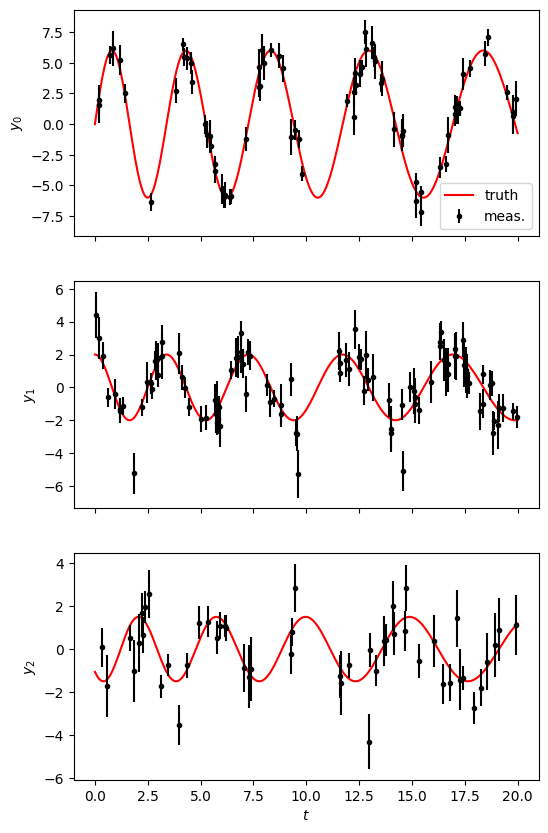

In [89]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Settings
P0 = 3.8
dP = 1.25
tmax = 20
amp = [6.0, 2.0, 1.5]
phase = [0, np.pi / 2, -3*np.pi / 4]
nt = [75, 100, 50]

offset = 0

# True signal
tsmooth = np.linspace(0, tmax, 400)
Psmooth = P0 + dP * (tsmooth / tmax - 1 / 2)
Ysignal = [
  ak * np.sin(2 * np.pi * tsmooth / Psmooth + pk) + offset 
  for ak, pk in zip(amp, phase)
]

# Generate observations calendars
T = [
  np.sort(
  np.concatenate((np.random.uniform(0, tmax / 2,
  ntk // 2), np.random.uniform(2 * tmax / 3.5 , tmax, (ntk + 1) // 2))))
  for ntk in nt
]

# Generate measurements with white noise
Yerr = [np.random.uniform(0.5, 1.5, ntk) for ntk in nt]
P = [P0 + dP * (tk / tmax - 1 / 2) for tk in T]
Y = [
  amp[k] * np.sin(2 * np.pi * T[k] / P[k] + phase[k]) +  offset + 
  np.random.normal(0, Yerr[k]) for k in range(3)
]

# Plot
_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for k in range(3):
  ax = axs[k]
  ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()

[ 4.62774905e+00  9.99984036e+02  7.06891415e-01 -1.84073980e+00
 -1.09475781e+00  8.84547309e-01  3.25517201e+00 -3.57958690e-01
 -3.87364464e-01]
['GP.P', 'GP.rho', 'GP.eta', 'GP.alpha_0', 'GP.alpha_1', 'GP.alpha_2', 'GP.beta_0', 'GP.beta_1', 'GP.beta_2']


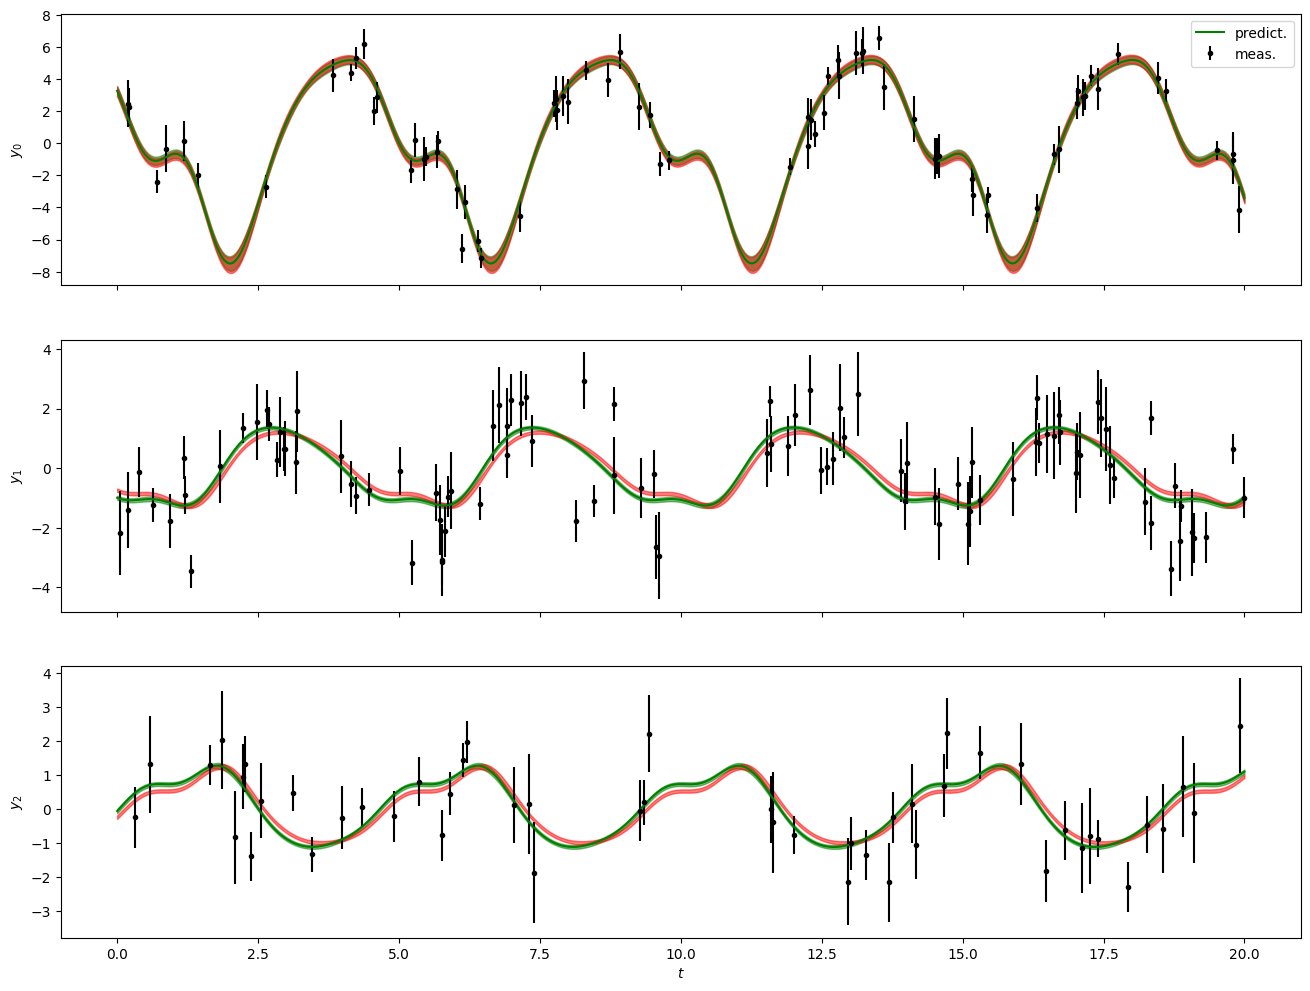

In [90]:
from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

# Merge all 3 time series
t_full, y_full, yerr_full, series_index = cov.merge_series(T, Y, Yerr)

# Initialize the S+LEAF model
C = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35, nharm=4), series_index,
  [6.0, 2.0, 0.33], np.ones(3)))

D = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35, nharm=4), series_index,
  [6.0, 2.0, 1.5], np.ones(3)))

# Fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
# List of parameters to fit
param = C.param[1:]
# The amplitude of the SHOKernel is fixed at 1 (not fitted),
# since it would be degenerated with the amplitudes alpha, \beta.

# Define the function to minimize
def negloglike(x, y, C):
  C.set_param(x, param)
  nll = -C.loglike(y)
  # gradient
  nll_grad = -C.loglike_grad()[1][1:]
  return (nll, nll_grad)

# Fit
xbest, _, _ = fmin_l_bfgs_b(negloglike, C.get_param(param), args=(y_full, C))

T_new = []
Y_new = []
C.set_param(xbest, param)

for k in range(3):
  # Predict time series k
  C.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_full, T[k], calc_cov='diag')
  Y_new.append(np.random.normal(mu_fit, 1.0))
  

t_new, y_new, yerr_new, series_index = cov.merge_series(T, Y_new, Yerr)

# Fit
xbest, _, _ = fmin_l_bfgs_b(negloglike, C.get_param(param), args=(y_new, C))
print(xbest)

new_test = xbest.copy()
new_test[3] = -3.

# Use S+LEAF to predict the missing data
C.set_param(xbest, param)
D.set_param(new_test, param)

print(param)
_, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
for k in range(3):
  # Predict time series k
  C.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_new, tsmooth, calc_cov='diag')

  D.kernel['GP'].set_conditional_coef(series_id=k)
  mu_mod, var_mod = D.conditional(y_new, tsmooth, calc_cov='diag')

    
  # Plot
  ax = axs[k]
  #ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y_new[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.fill_between(tsmooth,
    mu_fit - np.sqrt(var_fit),
    mu_fit + np.sqrt(var_fit),
    color='g',
    alpha=0.5)

  ax.fill_between(tsmooth,
    mu_mod - np.sqrt(var_mod),
    mu_mod + np.sqrt(var_mod),
    color='r',
    alpha=0.5)    
    
  ax.plot(tsmooth, mu_fit, 'g', label='predict.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()
plt.show()





In [91]:
import sys
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
#from tinygp.helpers import JAXArray

from ordered_set import OrderedSet

if sys.version_info[1] < 10:
    raise Warning("You should be using Python 3.10 - tinygp may not work")

class LatentKernel(kernels.Kernel):
    """A custom kernel based on Rajpaul et al. (2015)

    Args:
        kernel: The kernel function describing the latent process. This can be any other
            ``tinygp`` kernel.
        coeff_prim: The primal coefficients for each class. This can be thought of as how
            much the latent process itself projects into the observations for that class.
            This should be an array with an entry for each class of observation.
        coeff_deriv: The derivative coefficients for each class. This should have the same
            shape as ``coeff_prim``.
    """

    try:
        kernel : kernels.Kernel
        coeff_prim: jax.Array | float
        coeff_deriv: jax.Array | float
    except:
        pass

    def __init__(self, kernel, coeff_prim, coeff_deriv):
        self.kernel = kernel
        self.coeff_prim, self.coeff_deriv = jnp.broadcast_arrays(
            jnp.asarray(coeff_prim), jnp.asarray(coeff_deriv)
        )

    def evaluate(self, X1, X2):
        t1, label1 = X1
        t2, label2 = X2

        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel.evaluate, argnums=0)

        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)

        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)

        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)

        # Extract the coefficients
        a1 = self.coeff_prim[label1]
        a2 = self.coeff_prim[label2]
        b1 = self.coeff_deriv[label1]
        b2 = self.coeff_deriv[label2]

        # Construct the matrix element
        return (
            a1 * a2 * K
            + a1 * b2 * dK_dx2
            + b1 * a2 * dK_dx1
            + b1 * b2 * d2K_dx1dx2
        )


def _build_tinygp_multidimensional(params):

    base_kernel = kernels.ExpSquared(scale=jnp.abs(params["Pdec"])) \
            * kernels.ExpSineSquared(
            scale=jnp.abs(params["Prot"]),
            gamma=jnp.abs(params["gamma"]))

    kernel = LatentKernel(base_kernel, params['coeff_prime'], params['coeff_deriv'])
    return GaussianProcess(
        kernel, params['X'], diag=jnp.abs(params['diag']), mean=0.0
    )

@jax.jit
def _loss_tinygp(params):
    gp = _build_tinygp_multidimensional(params)
    return gp.log_probability(params['y'])

In [92]:

dataset_x0 = []
dataset_res = []
dataset_label = []
dataser_er2 = []

temp_input = []
temp_label = []

for ii in range(0, 3):
    temp_input = np.append(temp_input, tsmooth)
    temp_label = np.append(temp_label, np.zeros_like(tsmooth, dtype=int) + ii)

X_input = (temp_input, temp_label.astype(int))


for k in range(0,3):
    dataset_x0 = np.append(dataset_x0, T[k])
    dataset_label = np.append(dataset_label, np.zeros_like(T[k], dtype=int) + k)
    dataset_res = np.append(dataset_res, Y_new[k])
    dataser_er2 = np.append(dataser_er2, Yerr[k]**2)


tinygp_X = (dataset_x0, dataset_label.astype(int))

In [93]:
internal_parameter_values = xbest.copy()
theta_dict =  dict(
    gamma=1. / (2.*internal_parameter_values[2] ** 2),
    Pdec=internal_parameter_values[1],
    Prot=internal_parameter_values[0],
    diag=dataser_er2,
    X=tinygp_X,
    y=dataset_res,
    coeff_prime=internal_parameter_values[3:6],
    coeff_deriv=internal_parameter_values[6:],
    x_predict = X_input
)

gp = _build_tinygp_multidimensional(theta_dict)
_, cond_gp = gp.condition(theta_dict['y'], theta_dict['x_predict'])

#mu = cond_gp.mean
#std = np.sqrt(cond_gp.variance)
mu_full = cond_gp.loc # or cond_gp.mean?


In [94]:

from scipy.linalg import cho_factor, cho_solve, lapack, LinAlgError
from scipy import matrix, spatial

#from numba.experimental import jitclass

try:
    from numba import jit

    @jit(nopython=True)
    def _compute_submatrix(dist_t1, dist_t2, Prot, Prot2, Pdec2, Oamp2):
        phi = 2. * np.pi * dist_t1 / Prot
        sin_phi = np.sin(phi)
        pi2 = np.pi * np.pi

        framework_GG = np.exp((-(np.sin(phi / 2.)) ** 2.) / (2.0 * Oamp2)) \
            * np.exp(- dist_t2 / (2 * Pdec2))

        framework_GdG = framework_GG * (- (np.pi * sin_phi / (2 * Prot * Oamp2))
                                        - dist_t1 / Pdec2)

        framework_dGdG = framework_GG * (- (pi2 * sin_phi ** 2) / (4. * Prot2 * Oamp2 * Oamp2)
                                         + (pi2 * np.cos(phi))
                                         / (Prot2 * Oamp2)
                                         - phi * sin_phi / (2 * Oamp2 * Pdec2)
                                         - dist_t2 / (Pdec2 * Pdec2) + 1. / Pdec2)

        return framework_GG, framework_GdG, framework_dGdG

except:

    def _compute_submatrix(dist_t1, dist_t2, Prot, Prot2, Pdec2, Oamp2):
        phi = 2. * np.pi * dist_t1 / Prot
        sin_phi = np.sin(phi)
        pi2 = np.pi * np.pi

        framework_GG = np.exp((-(np.sin(phi / 2.)) ** 2.) / (2.0 * Oamp2)) \
            * np.exp(- dist_t2 / (2 * Pdec2))

        framework_GdG = framework_GG * (- (np.pi * sin_phi / (2 * Prot * Oamp2))
                                        - dist_t1 / Pdec2)

        framework_dGdG = framework_GG * (- (pi2 * sin_phi ** 2) / (4. * Prot2 * Oamp2 * Oamp2)
                                         + (pi2 * np.cos(phi))
                                         / (Prot2 * Oamp2)
                                         - phi * sin_phi / (2 * Oamp2 * Pdec2)
                                         - dist_t2 / (Pdec2 * Pdec2) + 1. / Pdec2)

        return framework_GG, framework_GdG, framework_dGdG


class Dataset():
    def __init__(self, name_ref, xx, yy, ee ):
        self.x0 = xx
        self.x = xx 
        self.n = len(xx)
        self.e = ee 
        self.y = yy
        self.res = yy
        self.name_ref = name_ref
        self.jitter = 0
        self.residuals = yy


class GP_Multidimensional_QuasiPeriodicActivity_Numba():

    default_common = 'activity'

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model_class = 'gp_multidimensional_quasiperiodic_activity'

        self.internal_likelihood = True
        self.delayed_lnlk_computation = True

        self.list_pams_common = OrderedSet([
            'Prot',  # Rotational period of the star
            'Pdec',  # Decay timescale of activity
            'Oamp',  # Granulation of activity
        ])
        self.list_pams_dataset = OrderedSet([
            'rot_amp', # Amplitude of the first derivative of the covariance matrix
            'con_amp' # Amplitude of the covariance matrix
        ])


        self.internal_parameter_values = None
        self._dist_t1 = None
        self._dist_t2 = None
        self._added_datasets = 0
        self.dataset_ordering = {}
        self.inds_cache = None

        self._dataset_x0 = []
        self._dataset_e2 = []
        self._dataset_names = {}

        self._dataset_nindex = []

        self.use_derivative_dict = {}

        self.internal_coefficients = []

        self._dataset_ej2 = []
        self._dataset_res = []

        self._added_datasets = 0
        self._n_cov_matrix = 0

        self.pi2 = np.pi * np.pi

    def initialize_model_dataset(self, dataset, **kwargs):

        """ when reloading the .p files, the object is not reinitialized, so we have to skip the
        incremental addition of datasets if they are already present  """
        if dataset.name_ref in self._dataset_names:
            return

        self._dataset_nindex.append([self._n_cov_matrix,
                                    self._n_cov_matrix+dataset.n])
        self.internal_coefficients.append([0.00, 0.00])

        self._dataset_x0.append(dataset.x0)

        self._dataset_e2 = np.append(self._dataset_e2, dataset.e**2)

        self._dataset_names[dataset.name_ref] = self._added_datasets
        self._n_cov_matrix += dataset.n
        self._added_datasets += 1

        self._dataset_ej2 = self._dataset_e2 * 1.
        self._dataset_res = self._dataset_e2 * 0.
        self._nugget = self._dataset_e2 * 0. + 1e-7

        self.inds_cache = np.tri(self._n_cov_matrix, k=-1, dtype=bool)

        self._dataset_dists = [[0] * self._added_datasets for i in range(self._added_datasets)]
        for l_dataset in range(self._added_datasets):
            for m_dataset in range(self._added_datasets):

                dist_t1, dist_t2 = self._compute_distance(self._dataset_x0[l_dataset],
                                                          self._dataset_x0[m_dataset])
                self._dataset_dists[l_dataset][m_dataset] = [dist_t1, dist_t2]

        return

    def add_internal_dataset(self, parameter_values, dataset):

        self.internal_parameter_values = parameter_values

        d_ind = self._dataset_names[dataset.name_ref]
        d_nstart, d_nend = self._dataset_nindex[d_ind]

        self._dataset_ej2[d_nstart:d_nend] = self._dataset_e2[d_nstart:d_nend] + dataset.jitter**2.0
        self._dataset_res[d_nstart:d_nend] = dataset.residuals

        self.internal_coefficients[d_ind] = [parameter_values['con_amp'], parameter_values['rot_amp']]

    def _compute_distance(self, bjd0, bjd1):
        X0 = np.array([bjd0]).T
        X1 = np.array([bjd1]).T
        return spatial.distance.cdist(X0, X1, lambda u, v: u-v), \
            spatial.distance.cdist(X0, X1, 'sqeuclidean')
        # Change after Rajpaul, Barragàn,  priv. comm.
        #return spatial.distance.cdist(X0, X1, lambda u, v: v-u), \
        #    spatial.distance.cdist(X0, X1, 'sqeuclidean')

    def _compute_cov_matrix(self):

        """ Notice the difference in the factor 2 of the decay time scale
            between Grunblatt+2015 (used for the "standard" GP model of PyORBIT) and Rajpaul+2015"""

        # this is faster than computing val**4 several times
        Prot = self.internal_parameter_values['Prot']
        Pdec2 = self.internal_parameter_values['Pdec']**2
        Prot2 = self.internal_parameter_values['Prot']**2
        Oamp2 = self.internal_parameter_values['Oamp']**2

        cov_matrix = np.empty([self._n_cov_matrix, self._n_cov_matrix])

        for l_dataset in range(0, self._added_datasets):
            for m_dataset in range(0, self._added_datasets):

                l_nstart, l_nend = self._dataset_nindex[l_dataset]
                m_nstart, m_nend = self._dataset_nindex[m_dataset]

                #dist_t1, dist_t2 = self._compute_distance(self._dataset_x0[l_dataset],
                #                                          self._dataset_x0[m_dataset])

                dist_t1, dist_t2 = self._dataset_dists[l_dataset][m_dataset]

                Al, Bl = self.internal_coefficients[l_dataset]
                Am, Bm = self.internal_coefficients[m_dataset]

                framework_GG, framework_GdG, framework_dGdG = \
                    _compute_submatrix(dist_t1, dist_t2,
                                       Prot, Prot2, Pdec2, Oamp2)

                k_lm = Al * Am * framework_GG \
                        + Bl * Bm * framework_dGdG \
                        + Al * Bm * framework_GdG \
                        - Bl * Am * framework_GdG

                cov_matrix[l_nstart:l_nend, m_nstart:m_nend] = k_lm
                #cov_matrix[l_nstart:l_nend, m_nstart:m_nend] = matrix(k_lm)

        cov_matrix += np.diag(self._dataset_ej2)

        return cov_matrix

    def _compute_cov_diag(self, t_array):

        """ Notice the difference in the factor 2 of the decay time scale
            between Grunblatt+2015 (used for the "standard" GP model of PyORBIT) and Rajpaul+2015"""

        # this is faster than computing val**4 several times
        Prot = self.internal_parameter_values['Prot']
        Pdec2 = self.internal_parameter_values['Pdec']**2
        Prot2 = self.internal_parameter_values['Prot']**2
        Oamp2 = self.internal_parameter_values['Oamp']**2

        len_diag = len(t_array)
        cov_diag = np.empty(self._added_datasets*len_diag)
        dist_t1, dist_t2 = np.zeros(len_diag), np.zeros(len_diag)


        for l_dataset in range(0, self._added_datasets):
            l_nstart, l_nend = l_dataset*len_diag,  (l_dataset+1)*len_diag

            Al, Bl = self.internal_coefficients[l_dataset]

            framework_GG, framework_GdG, framework_dGdG = \
                _compute_submatrix(dist_t1, dist_t2,
                                    Prot, Prot2, Pdec2, Oamp2)

            k_lm = Al * Al * framework_GG + Bl * Bl * framework_dGdG

            cov_diag[l_nstart:l_nend] = k_lm

        return cov_diag


    def _compute_cov_Ks(self, t_array):

        """ Notice the difference in the factor 2 of the decay time scale
            between Grunblatt+2015 (used for the "standard" GP model of PyORBIT) and Rajpaul+2015"""

        # this is faster than computing val**4 several times
        Prot = self.internal_parameter_values['Prot']
        Pdec2 = self.internal_parameter_values['Pdec']**2
        Prot2 = self.internal_parameter_values['Prot']**2
        Oamp2 = self.internal_parameter_values['Oamp']**2

        len_t_array = len(t_array)
        cov_matrix = np.empty([self._added_datasets*len_t_array, self._n_cov_matrix])

        for l_dataset in range(0, self._added_datasets):
            for m_dataset in range(0, self._added_datasets):

                l_nstart, l_nend = l_dataset*len_t_array,  (l_dataset+1)*len_t_array
                m_nstart, m_nend = self._dataset_nindex[m_dataset]


                dist_t1, dist_t2 = self._compute_distance(t_array,
                                                          self._dataset_x0[m_dataset])

                Al, Bl = self.internal_coefficients[l_dataset]
                Am, Bm = self.internal_coefficients[m_dataset]

                framework_GG, framework_GdG, framework_dGdG = \
                    _compute_submatrix(dist_t1, dist_t2,
                                       Prot, Prot2, Pdec2, Oamp2)

                k_lm = Al * Am * framework_GG \
                        + Bl * Bm * framework_dGdG \
                        + Al * Bm * framework_GdG \
                        - Bl * Am * framework_GdG

                cov_matrix[l_nstart:l_nend, m_nstart:m_nend] = k_lm

        #cov_matrix += np.diag(self._nugget)

        return cov_matrix


    # https://stackoverflow.com/questions/40703042/more-efficient-way-to-invert-a-matrix-knowing-it-is-symmetric-and-positive-semi
    def fast_positive_definite_inverse(self, m):

        cholesky, info = lapack.dpotrf(m)

        if info != 0:
            return None, None, True

        detA = 2*np.sum(np.log(np.diagonal(cholesky)))

        inv, info = lapack.dpotri(cholesky)
        if info != 0:
            return None, None, True

        inv[self.inds_cache] = inv.T[self.inds_cache]
        return inv, detA, False

    def lnlk_compute(self):

        cov_matrix = self._compute_cov_matrix()

        inv_M, det_A, failed = self.fast_positive_definite_inverse(cov_matrix)

        if failed:
            return -np.inf

        chi2 = np.dot(self._dataset_res, np.matmul(inv_M, self._dataset_res))
        log2_npi = self._n_cov_matrix * np.log(2 * np.pi)
        output = -0.5 * (log2_npi + chi2 + det_A)
        return output

        #cov_matrix = self._compute_cov_matrix(add_diagonal_errors=True)
        #chi2 = np.dot(_3res,np.matmul(inv_M,_3res))
        #
        # try:
        #    alpha = cho_solve(cho_factor(cov_matrix), self._3res)
        #    (s, d) = np.linalg.slogdet(cov_matrix)
        #
        #    return -0.5 * (self.n * np.log(2 * np.pi) +
        #                   np.dot(self._3res, alpha) + d)
        # except:
        #    return -np.inf

    def sample_predict(self, dataset, x0_input=None, return_covariance=False, return_variance=False):

        dataset_index = self._dataset_names[dataset.name_ref]

        if x0_input is None:
            faster_computation = False
            t_predict = dataset.x0
            l_nstart, l_nend = self._dataset_nindex[dataset_index]
        else:
            faster_computation = True
            t_predict = x0_input
            l_nstart, l_nend = len(x0_input)*dataset_index, len(x0_input)*(dataset_index+1)

        cov_matrix = self._compute_cov_matrix()

        if faster_computation:
            Ks = self._compute_cov_Ks(t_predict)
        else:
            Ks = cov_matrix - np.diag(self._dataset_ej2)

        alpha = cho_solve(cho_factor(cov_matrix), self._dataset_res)
        mu = np.dot(Ks, alpha).flatten()
        (s, d) = np.linalg.slogdet(cov_matrix)

        B = cho_solve(cho_factor(cov_matrix), Ks.T)
        KsB_dot_diag = np.diag(np.dot(Ks, B))

        B = None
        Ks = None

        if faster_computation:
            Kss = self._compute_cov_diag(t_predict)
        else:
            Kss = np.diag(cov_matrix)
        cov_matrix = None

        std = np.sqrt(np.array(Kss - KsB_dot_diag).flatten())

        Kss = None

        if return_covariance:
            print('Covariance matrix output not implemented - ERROR')
            quit()

        if return_variance:
            return mu[l_nstart:l_nend], std[l_nstart:l_nend]
        else:
            return mu[l_nstart:l_nend]

    def sample_conditional(self, dataset, x0_input=None):
        val, std = self.sample_predict(dataset, x0_input)
        return val

parameter_values = {
    'Prot': xbest[0],
    'Pdec': xbest[1],
    'Oamp': xbest[2]
}
#['GP.P', 'GP.rho', 'GP.eta', 'GP.alpha_0', 'GP.alpha_1', 'GP.alpha_2', 'GP.beta_0', 'GP.beta_1', 'GP.beta_2']


dataset_00 = Dataset('dataset_00', T[0], Y_new[0], Yerr[0])
dataset_01 = Dataset('dataset_01', T[1], Y_new[1], Yerr[1])
dataset_02 = Dataset('dataset_02', T[2], Y_new[2], Yerr[2])

GP_multi_xbest = GP_Multidimensional_QuasiPeriodicActivity_Numba()

GP_multi_xbest.initialize_model_dataset(dataset_00)
GP_multi_xbest.initialize_model_dataset(dataset_01)
GP_multi_xbest.initialize_model_dataset(dataset_02)

parameter_values['con_amp'] = xbest[3]
parameter_values['rot_amp'] = -xbest[6]
GP_multi_xbest.add_internal_dataset(parameter_values, dataset_00)

parameter_values['con_amp'] = xbest[4]
parameter_values['rot_amp'] = -xbest[7]
GP_multi_xbest.add_internal_dataset(parameter_values, dataset_01)

parameter_values['con_amp'] = xbest[5]
parameter_values['rot_amp'] = -xbest[8]
GP_multi_xbest.add_internal_dataset(parameter_values, dataset_02)


GP_multi_newtest = GP_Multidimensional_QuasiPeriodicActivity_Numba()
GP_multi_newtest.initialize_model_dataset(dataset_00)
GP_multi_newtest.initialize_model_dataset(dataset_01)
GP_multi_newtest.initialize_model_dataset(dataset_02)



['GP.P', 'GP.rho', 'GP.eta', 'GP.alpha_0', 'GP.alpha_1', 'GP.alpha_2', 'GP.beta_0', 'GP.beta_1', 'GP.beta_2']


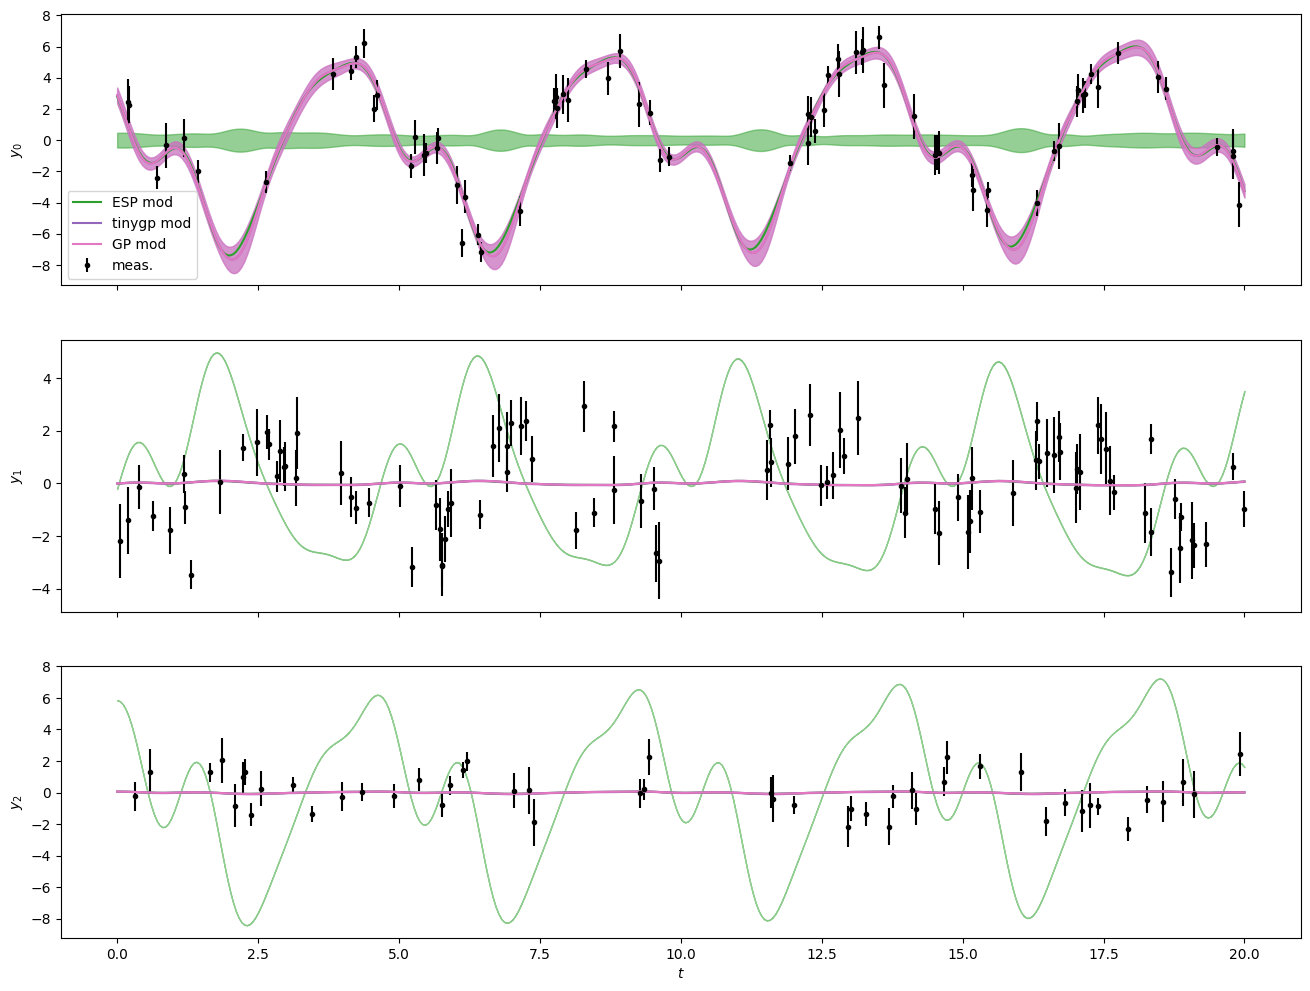

In [98]:
new_test = xbest.copy()

new_test[3] = 100.
##new_test[4] = 2.
##new_test[5] = 2.


parameter_values = {
    'Prot': xbest[0],
    'Pdec': xbest[1],
    'Oamp': xbest[2]
}
parameter_values['con_amp'] = new_test[3]
parameter_values['rot_amp'] = -new_test[6]
GP_multi_newtest.add_internal_dataset(parameter_values, dataset_00)

parameter_values['con_amp'] = new_test[4]
parameter_values['rot_amp'] = -new_test[7]
GP_multi_newtest.add_internal_dataset(parameter_values, dataset_01)

parameter_values['con_amp'] = new_test[5]
parameter_values['rot_amp'] = -new_test[8]
GP_multi_newtest.add_internal_dataset(parameter_values, dataset_02)


internal_parameter_values = new_test.copy()
theta_dict_mod =  dict(
    gamma=1. / (2.*internal_parameter_values[2] ** 2),
    Pdec=internal_parameter_values[1],
    Prot=internal_parameter_values[0],
    diag=dataser_er2,
    X=tinygp_X,
    y=dataset_res,
    coeff_prime=internal_parameter_values[3:6],
    coeff_deriv=internal_parameter_values[6:],
    x_predict = X_input
)

gp_mod = _build_tinygp_multidimensional(theta_dict_mod)
_, cond_gp_mod = gp_mod.condition(theta_dict_mod['y'], theta_dict_mod['x_predict'])

#mu = cond_gp.mean
#std = np.sqrt(cond_gp.variance)
mu_full_mod = cond_gp_mod.loc # or cond_gp.mean?


D = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35, nharm=4), series_index,
  [6.0, 2.0, 1.5], np.ones(3)))






# Use S+LEAF to predict the missing data
C.set_param(xbest, param)
D.set_param(new_test, param)

plot_original = False

print(param)
_, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
for k in range(3):
  # Predict time series k
  C.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_new, tsmooth, calc_cov='diag')

  D.kernel['GP'].set_conditional_coef(series_id=k)
  mu_mod, var_mod = D.conditional(y_new, tsmooth, calc_cov='diag')

  if k==0:
        standardGP_val_full, standardGP_mu_full = GP_multi_xbest.sample_predict(dataset_00, x0_input=tsmooth, return_variance=True)
        standardGP_val_mod, standardGP_mu_mod = GP_multi_newtest.sample_predict(dataset_00, x0_input=tsmooth, return_variance=True)
  if k==1:
        standardGP_val_full, standardGP_mu_full = GP_multi_xbest.sample_predict(dataset_01, x0_input=tsmooth, return_variance=True)
        standardGP_val_mod, standardGP_mu_mod = GP_multi_newtest.sample_predict(dataset_01, x0_input=tsmooth, return_variance=True)
  if k==2:
        standardGP_val_full, standardGP_mu_full = GP_multi_xbest.sample_predict(dataset_02, x0_input=tsmooth, return_variance=True)
        standardGP_val_mod, standardGP_mu_mod = GP_multi_newtest.sample_predict(dataset_02, x0_input=tsmooth, return_variance=True)

  # Predict time series k
  l_nstart, l_nend = len(tsmooth)*k, len(tsmooth)*(k+1)

  tinygp_mu = mu_full[l_nstart:l_nend]
  tinygp_std = np.sqrt(cond_gp.variance)[l_nstart:l_nend]
  tinygp_mu_mod = mu_full_mod[l_nstart:l_nend]
  tinygp_std_mod = np.sqrt(cond_gp_mod.variance)[l_nstart:l_nend]
    
  # Plot
  ax = axs[k]
  #ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y_new[k], Yerr[k], fmt='.', color='k', label='meas.')

    
  if plot_original:  
      ax.fill_between(tsmooth,
        mu_fit - np.sqrt(var_fit),
        mu_fit + np.sqrt(var_fit),
        color='C1',
        alpha=0.15)
      ax.plot(tsmooth, mu_fit, 'C1', label='ESP fit')

      ax.fill_between(tsmooth,
        tinygp_mu - tinygp_std,
        tinygp_mu + tinygp_std,
        color='C3',
        alpha=0.15)
      ax.plot(tsmooth, tinygp_mu, 'C3', label='tinygp fit')

      ax.fill_between(tsmooth,
        standardGP_val_full - standardGP_mu_full,
        standardGP_val_full + standardGP_mu_full,
        color='C5',
        alpha=0.15)
      ax.plot(tsmooth, tinygp_mu_mod, 'C5', label='GP fit')

        
  ax.fill_between(tsmooth,
    mu_mod - np.sqrt(var_mod),
    mu_mod + np.sqrt(var_mod),
    color='C2',
    alpha=0.5)    
  ax.plot(tsmooth, mu_mod, 'C2', label='ESP mod')

  ax.fill_between(tsmooth,
    tinygp_mu_mod - tinygp_std_mod,
    tinygp_mu_mod + tinygp_std_mod,
    color='C4',
    alpha=0.5)
  ax.plot(tsmooth, tinygp_mu_mod, 'C4', label='tinygp mod')


  ax.fill_between(tsmooth,
    standardGP_val_mod - standardGP_mu_mod,
    standardGP_val_mod + standardGP_mu_mod,
    color='C6',
    alpha=0.5)
  ax.plot(tsmooth, tinygp_mu_mod, 'C6', label='GP mod')
    
    
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()
plt.show()


In [11]:
internal_parameter_values = xbest.copy()
theta_dict =  dict(
    gamma=1. / (2.*internal_parameter_values[2] ** 2),
    Pdec=internal_parameter_values[1],
    Prot=internal_parameter_values[0],
    diag=dataser_er2,
    X=tinygp_X,
    y=dataset_res,
    coeff_prime=internal_parameter_values[3:6],
    coeff_deriv=internal_parameter_values[6:],
    x_predict = X_input
)

gp = _build_tinygp_multidimensional(theta_dict)
_, cond_gp_mod = gp.condition(theta_dict['y'], theta_dict['x_predict'])

#mu = cond_gp.mean
#std = np.sqrt(cond_gp.variance)
mu_full_mod = cond_gp_mod.loc # or cond_gp.mean?


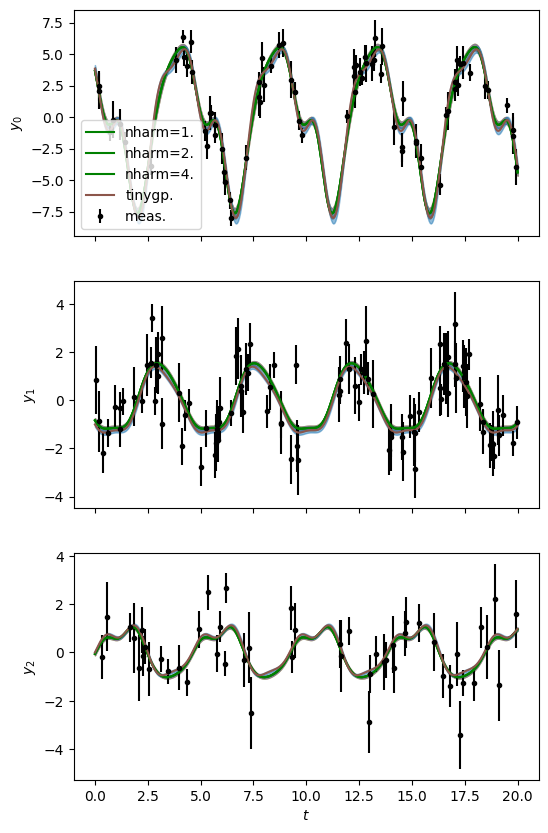

In [12]:
C1 = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35, nharm=1), series_index,
  [6.0, 2.0, 1.5], np.ones(3)))

C2 = cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35, nharm=2), series_index,
  [6.0, 2.0, 1.5], np.ones(3)))

C3= cov.Cov(t_full,
  err=term.Error(yerr_full),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35, nharm=3), series_index,
  [6.0, 2.0, 1.5], np.ones(3)))

C1.set_param(xbest, param)
C2.set_param(xbest, param)
C3.set_param(xbest, param)



_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))

for k in range(3):

  # Predict time series k
  C.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_full, tsmooth, calc_cov='diag')  
    
  # Predict time series k
  l_nstart, l_nend = len(tsmooth)*k, len(tsmooth)*(k+1)

  tinygp_mu = mu_full[l_nstart:l_nend]
  tinygp_std = np.sqrt(cond_gp.variance)[l_nstart:l_nend]

  # Plot
  ax = axs[k]
  #ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y_new[k], Yerr[k], fmt='.', color='k', label='meas.')


  # Predict time series k
  C1.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_full, tsmooth, calc_cov='diag')  
    
  ax.fill_between(tsmooth,
    mu_fit - np.sqrt(var_fit),
    mu_fit + np.sqrt(var_fit),
    color='C1',
    alpha=0.5)
  ax.plot(tsmooth, mu_fit, 'g', label='nharm=1.')  

  # Predict time series k
  C2.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_full, tsmooth, calc_cov='diag')  
    
  ax.fill_between(tsmooth,
    mu_fit - np.sqrt(var_fit),
    mu_fit + np.sqrt(var_fit),
    color='C2',
    alpha=0.5)
  ax.plot(tsmooth, mu_fit, 'g', label='nharm=2.')  






  # Predict time series k
  C.kernel['GP'].set_conditional_coef(series_id=k)
  mu_fit, var_fit = C.conditional(y_full, tsmooth, calc_cov='diag')  
    
  ax.fill_between(tsmooth,
    mu_fit - np.sqrt(var_fit),
    mu_fit + np.sqrt(var_fit),
    color='C4',
    alpha=0.5)
  ax.plot(tsmooth, mu_fit, 'g', label='nharm=4.')  

  ax.fill_between(tsmooth,
    tinygp_mu - tinygp_std,
    tinygp_mu + tinygp_std,
    color='C0',
    alpha=0.5)
  ax.plot(tsmooth, tinygp_mu, 'C5', label='tinygp.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()
plt.show()

